In [70]:
import numpy as np
import matplotlib.pyplot as plt
R1 = 1 #in Rj
R2 = 1

def rstep(t, i, M1, M2, anorm, e, tau1, tau2):
    nsteps = 200
    Es = np.linspace(0, 2*np.pi, nsteps)
    ts = Es - e*np.sin(Es)
    t = t % (2*np.pi)
    E = Es[np.argmin(np.abs(ts - t))] #eccentric anomaly

    a1 = anorm*(M2/M1) #in Rj
    a2 = anorm

    r1 = np.array([np.cos(tau1)*a1*(np.cos(E)-e), np.sin(i)*np.cos(tau1)*a1*np.sqrt(1-e**2)*np.sin(E)])
    r2 = np.array([np.cos(tau2)*a2*(np.cos(E)-e), np.sin(i)*np.cos(tau2)*a2*np.sqrt(1-e**2)*np.sin(E)])
    return r1, r2

def simulateorbits(i=90*(np.pi/180.), M1=1, M2=1, anorm=2, e=0, tau1=0, tau2=np.pi, iterations=10000, t=0, dt=0.01):
    r1s = []
    r2s = []
    for iteration in range(iterations):
        r1, r2 = rstep(t, i, M1, M2, anorm, e, tau1, tau2)
        r1s.append(r1)
        r2s.append(r2)
        t += dt
    return np.array(r1s), np.array(r2s)
        
def draworbits(r1s, r2s, M1, M2):
    normdim = 6
    xrange = max(max(np.max(r1s[:, 0]), np.max(r2s[:, 0]))-min(np.min(r1s[:, 0]), np.min(r2s[:, 0])), 2)
    yrange = max(max(np.max(r1s[:, 1]), np.max(r2s[:, 1]))-min(np.min(r1s[:, 1]), np.min(r2s[:, 1])), 2)
    plt.figure(figsize=(xrange/yrange*normdim, normdim))
    plt.plot(r1s[:, 0], r1s[:, 1])
    plt.plot(r2s[:, 0], r2s[:, 1])
    plt.scatter(np.array((r1s*M1+r2s*M2)/(M1+M2))[:, 0], np.array((r1s*M1+r2s*M2)/(M1+M2))[:, 1])
    plt.show()
    plt.clf()
    
def areaOverlap(r1s, r2s, R1, R2):
    d = np.linalg.norm(r2s-r1s, axis=1)
    d1 = (R1**2 - R2**2 + d**2)/(2*d)
    d2 = d - d1
    A = R1**2 * np.arccos(d1/R1) - d1*np.sqrt(R1**2-d1**2) + R2**2 * np.arccos(d2/R2) - d2*np.sqrt(R2**2-d2**2) # intersection area
    A[np.where(np.linalg.norm(r2s-r1s, axis=1) >= R1+R2)] = 0
    A[np.where(np.linalg.norm(r2s-r1s, axis=1) <= np.abs(R1-R2))] = np.pi * min(R1, R2)**2
    return A

def intersection(x1, y1, x2, y2, R1, R2):
    r1 = np.array([x1, y1])
    r2 = np.array([x2, y2])
    d = r2-r1 #distance between centers
    if np.linalg.norm(d) > R1+R2 or np.linalg.norm(d) < np.abs(R1-R2): #cases of zero intersections
        return np.array([])
    elif np.linalg.norm(d) == R1+R2: #1 grazing intersection, circles have no overlap
        return r1 + R1*(d/np.linalg.norm(d))
    elif np.linalg.norm(d) == np.abs(R1-R2): #1 grazing intersection, one circle inside the other
        if R1 < R2: #p1 contained within p2
            return r1 - R1*(d/np.linalg.norm(d))
        else:
            return r1 + R1*(d/np.linalg.norm(d))
    else: #case of 2 intersections
        x = (np.linalg.norm(d)**2 + R1**2 - R2**2)/(2*np.linalg.norm(d))
        theta = np.arccos(x/R1)
        i1 = r1 + np.matmul(np.matrix([[np.cos(theta), np.sin(-theta)], [np.sin(theta), np.cos(theta)]]), 
                       (R1 * (d/np.linalg.norm(d))))[0]
        i2 = r1 + np.matmul(np.matrix([[np.cos(theta), np.sin(theta)], [np.sin(-theta), np.cos(theta)]]), 
                       (R1 * (d/np.linalg.norm(d))))[0]
        return np.array([i1, i2])

def liesInCircle(x1, y1, x2, y2, R): #checks if point (x1, y1) lies within circle with center (x2, y2) and radius (R)
    return ((x1 - x2)**2 + (y1 - y2)**2) <= R**2

def threeAreaOverlap(data): #checks the area of overlap between ALL three circles
    x1 = data[0] #planet 1
    y1 = data[1]
    x2 = data[2] #planet 2
    y2 = data[3]
    x3 = data[4] #star
    y3 = data[5]
    R1 = data[6] #planet 1
    R2 = data[7] #planet 2
    R3 = data[8] #star
    r1 = np.array([x1, y1])
    r2 = np.array([x2, y2])
    r3 = np.array([x3, y3])
    i12 = intersection(x1, y1, x2, y2, R1, R2)
    i13 = intersection(x1, y1, x3, y3, R1, R3)
    i23 = intersection(x2, y2, x3, y3, R2, R3)
    if len(i13) < 2: #p1 lies completely inside or outside the star
        if liesInCircle(x1, y1, x3, y3, R3): #p1 lies completely inside the star
            return areaOverlap(np.array([np.array([x1, y1])]), np.array([np.array([x2, y2])]), 
                               R1, R2)[0] #give overlap of p1 and p2
        else:
            return 0.
    elif len(i23) < 2: #p2 lies completely inside or outside the star
        if liesInCircle(x2, y2, x3, y3, R3): #p2 lies completely inside the star
            return areaOverlap(np.array([np.array([x1, y1])]), np.array([np.array([x2, y2])]), 
                               R1, R2)[0] #give overlap of p1 and p2
        else:
            return 0.
    else: #p1 and p2 each have 2 intersections with the star
        aas = np.zeros((3, 2))
        bs = np.zeros((3, 2, 2))
        Rs, sidelens, areas = [R1, R2, R3], np.zeros(3), np.zeros(3)
        perms = [[i23, r1, R1], [i13, r2, R2], [i12, r3, R3]] #permutations of intersection and center points
        for perm in range(len(perms)):
            iis = perms[perm][0] #intersection points
            valid = False #remains false when one planet's intersection with the star is a subset of the other
                            #planet's intersection with the star
            for ii in iis:
                if liesInCircle(ii[0, 0], ii[0, 1], perms[perm][1][0], perms[perm][1][1], perms[perm][2]):
                    aas[perm][0], aas[perm][1] = ii[0, 0], ii[0, 1]
                    valid = True
                    break
            if not valid:
                return min(areaOverlap(np.array([np.array([x1, y1])]), np.array([np.array([x3, y3])]), R1, R3)[0],
                           areaOverlap(np.array([np.array([x2, y2])]), np.array([np.array([x3, y3])]), R2, R3)[0])
        perms = [[r1, [aas[1], aas[2]]], [r2, [aas[0], aas[2]]], [r3, [aas[0], aas[1]]]]
        for perm in range(len(perms)):
            for ii in range(len(perms[perm][1])):
                bs[perm][ii] = perms[perm][1][ii] - perms[perm][0]
        for b in range(len(bs)):
            sidelens[b] = np.linalg.norm(bs[b, 0] - bs[b, 1])
            x = Rs[b] * np.cos(np.arccos(bs[b, 0]@bs[b, 1]/Rs[b]**2)/2)
            areas[b] = Rs[b]**2 * np.pi/2 - Rs[b]**2 * np.arcsin(x/Rs[b]) - x*np.sqrt(Rs[b]**2-x**2)
        S = np.sum(sidelens)/2
        return np.sum(areas) + np.sqrt(S*(S-sidelens[0])*(S-sidelens[1])*(S-sidelens[2])) #use heron's formula for tri area
    
def transitDepth(r1s, r2s, rss, R1, R2, Rs, iterations=10000):
    radii = np.append(np.append(np.full(iterations, R1), np.full(iterations, R2)), 
              np.full(iterations, Rs)).reshape(3, iterations).T
    inputarr = np.append(np.append(np.append(r1s, r2s, axis=1), rss, axis=1), radii, axis=1)
    threeAreas = np.apply_along_axis(threeAreaOverlap, 1, inputarr)
    return (areaOverlap(r1s, rss, R1, Rs) + areaOverlap(r2s, rss, R2, Rs) - threeAreas) / (np.pi * Rs**2)

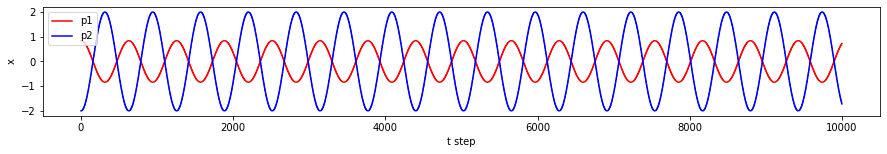

<Figure size 432x288 with 0 Axes>

In [71]:
it = 10000
R1 = 1
R2 = .75
Rs = 10
r1s, r2s = simulateorbits(i=0, M1=1, M2=.42, anorm=2, e=0, tau1=0, tau2=np.pi, iterations=it, 
                          t=0, dt=0.01) + np.append(np.linspace(-15., 15., it), np.zeros(it)).reshape(2, it).T
rss = np.zeros((it, 2))

plt.figure(figsize=(15, 2))
plt.plot(r1s[:, 0] - np.linspace(-15., 15., it), color='red', label='p1')
plt.plot(r2s[:, 0] - np.linspace(-15., 15., it), color='blue', label='p2')
plt.xlabel('t step')
plt.ylabel('x')
plt.legend()
plt.show()
plt.clf()

Text(0, 0.5, 'x')

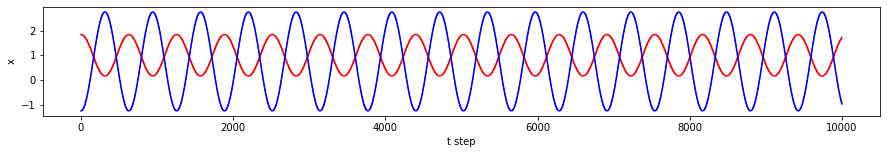

In [65]:
plt.figure(figsize=(15, 2))
plt.plot(r1s[:, 0] - np.linspace(-15., 15., it) + R1, color='red', label='p1')
plt.plot(r2s[:, 0] - np.linspace(-15., 15., it) + R2, color='blue', label='p2')
plt.xlabel('t step')
plt.ylabel('x')

# R1 = 1
# R2 = .75
# t = np.linspace(0, 32*np.pi, 10000)
# plt.plot((R2/R1)**3*np.cos(t)+R1, color='red')
# plt.plot(-np.cos(t)+R2, color='blue')

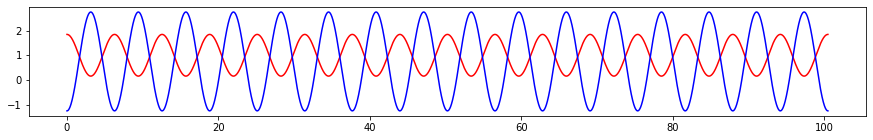

In [62]:
plt.figure(figsize=(15, 2))
R1 = 1.
R2 = .75
a_2 = 2.
a_1 = (R2/R1)**3 * a_2
t = np.linspace(0, 32*np.pi, 10000)
plt.plot(t, a_1*np.cos(t)+R1, color='red')
plt.plot(t, -a_2*np.cos(t)+R2, color='blue')

0.9258681588575312
1.0


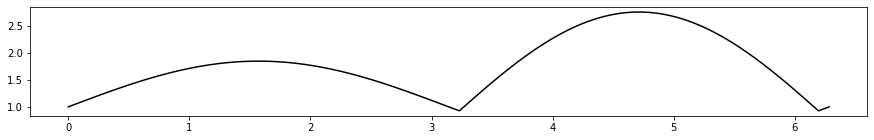

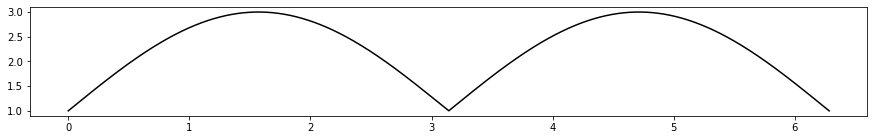

In [69]:
t = np.linspace(0, 2*np.pi, 10000)
R1 = 1.
R2 = .75
a_2 = 2.
a_1 = (R2/R1)**3 * a_2
plt.figure(figsize=(15, 2))
plt.plot(t, np.maximum(a_1*np.sin(t)+R1, -a_2*np.sin(t)+R2), color='black')
print(np.min(np.maximum(a_1*np.sin(t)+R1, -a_2*np.sin(t)+R2)))

R1 = 1.
R2 = 1.
a_2 = 2.
a_1 = (R2/R1)**3 * a_2
plt.figure(figsize=(15, 2))
plt.plot(t, np.maximum(a_1*np.sin(t)+R1, -a_2*np.sin(t)+R2), color='black')
print(np.min(np.maximum(a_1*np.sin(t)+R1, -a_2*np.sin(t)+R2)))

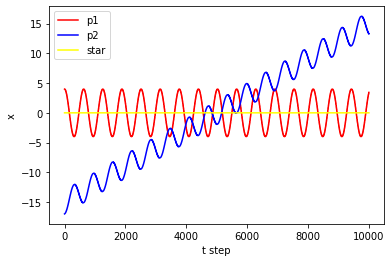

<ipython-input-70-ea2c09453252>:45: RuntimeWarning: invalid value encountered in arccos
  A = R1**2 * np.arccos(d1/R1) - d1*np.sqrt(R1**2-d1**2) + R2**2 * np.arccos(d2/R2) - d2*np.sqrt(R2**2-d2**2) # intersection area
<ipython-input-70-ea2c09453252>:45: RuntimeWarning: invalid value encountered in sqrt
  A = R1**2 * np.arccos(d1/R1) - d1*np.sqrt(R1**2-d1**2) + R2**2 * np.arccos(d2/R2) - d2*np.sqrt(R2**2-d2**2) # intersection area


Text(0, 0.5, 'F')

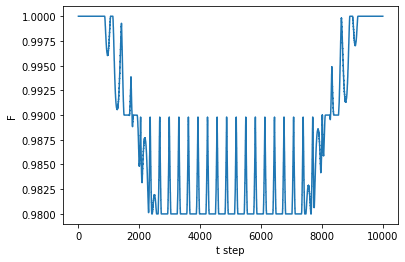

In [72]:
it = 10000
R1 = 1
R2 = 1
Rs = 10
r1s, r2s = simulateorbits(i=0, M1=1, M2=1, anorm=2, e=0, tau1=0, tau2=np.pi, iterations=it, 
                          t=0, dt=0.01) + np.append(np.linspace(-15., 15., it), np.zeros(it)).reshape(2, it).T
rss = np.zeros((it, 2))

plt.figure()
plt.plot(r1s[:, 0]-r2s[:, 0], label='p1', color='red')
plt.plot(r2s[:, 0], label='p2', color='blue')
plt.plot(rss[:, 0], label='star', color='yellow')
plt.xlabel('t step')
plt.ylabel('x')
plt.legend()
plt.show()
plt.clf()

delta = transitDepth(r1s, r2s, rss, R1, R2, Rs, iterations=it)
F = np.full(it, 1) - delta
plt.plot(F)
plt.xlabel('t step')
plt.ylabel('F')

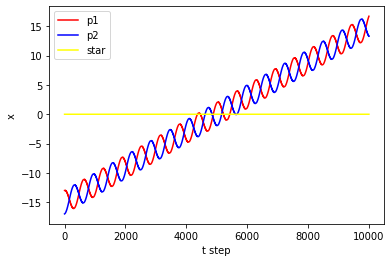

<ipython-input-70-ea2c09453252>:45: RuntimeWarning: invalid value encountered in arccos
  A = R1**2 * np.arccos(d1/R1) - d1*np.sqrt(R1**2-d1**2) + R2**2 * np.arccos(d2/R2) - d2*np.sqrt(R2**2-d2**2) # intersection area
<ipython-input-70-ea2c09453252>:45: RuntimeWarning: invalid value encountered in sqrt
  A = R1**2 * np.arccos(d1/R1) - d1*np.sqrt(R1**2-d1**2) + R2**2 * np.arccos(d2/R2) - d2*np.sqrt(R2**2-d2**2) # intersection area


Text(0, 0.5, 'F')

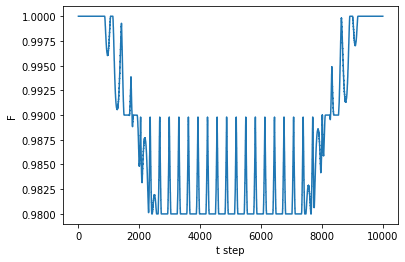

In [73]:
it = 10000
R1 = 1
R2 = 1
Rs = 10
r1s, r2s = simulateorbits(i=0, M1=1, M2=1, anorm=2, e=0, tau1=0, tau2=np.pi, iterations=it, 
                          t=0, dt=0.01) + np.append(np.linspace(-15., 15., it), np.zeros(it)).reshape(2, it).T
rss = np.zeros((it, 2))

plt.figure()
plt.plot(r1s[:, 0], label='p1', color='red')
plt.plot(r2s[:, 0], label='p2', color='blue')
plt.plot(rss[:, 0], label='star', color='yellow')
plt.xlabel('t step')
plt.ylabel('x')
plt.legend()
plt.show()
plt.clf()

delta = transitDepth(r1s, r2s, rss, R1, R2, Rs, iterations=it)
F = np.full(it, 1) - delta
plt.plot(F)
plt.xlabel('t step')
plt.ylabel('F')